In [1]:
import pandas as pd
from file_paths_and_consts import *
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
plt.style.use('classic')
import seaborn as sns
import geopandas as gpd
import random
sns.set()
import os
SEED_VALUE = 590
random.seed(SEED_VALUE)

OUTPUT_DIR

'/project/biocomplexity/UKR_forecast/migration_data/output_data/'

In [2]:
ROLLING = 30
refugee_data_file = 'burundi_refugee.csv'
refugee_data = pd.read_csv(refugee_data_file)
refugee_data['time'] = pd.to_datetime(refugee_data['time'])
refugee_data = refugee_data.resample('D',on='time').mean().interpolate().reset_index()
refugee_data['refugee'] = refugee_data['refugee'].diff()
refugee_data = refugee_data.dropna(subset=['refugee'])
refugee_data['refugee'] = refugee_data['refugee'].rolling(ROLLING).mean()
refugee_data = refugee_data.dropna(subset=['refugee'])
refugee_data

,time,refugee
30,2015-05-10,834.433333
31,2015-05-11,876.678974
32,2015-05-12,918.924615
33,2015-05-13,961.170256
34,2015-05-14,1003.415897
...,...,...
447,2016-06-30,118.113333
448,2016-07-01,123.826667
449,2016-07-02,129.540000
450,2016-07-03,123.833333


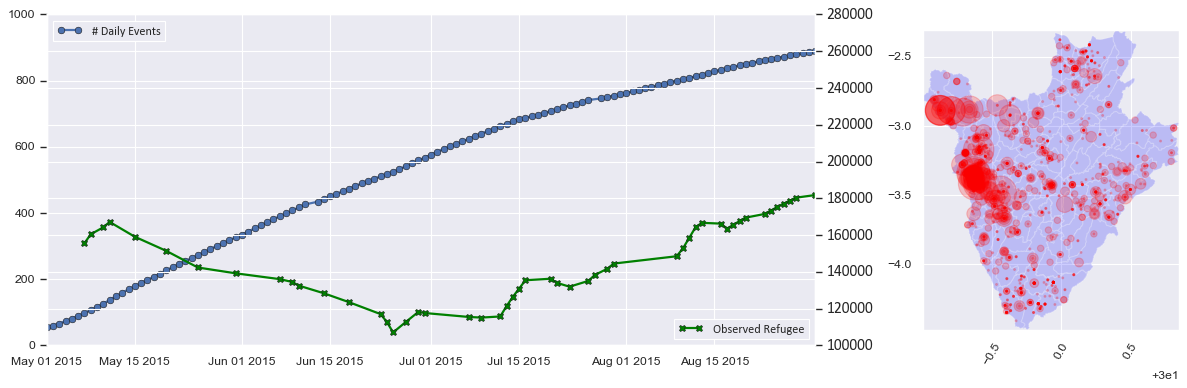

In [3]:
ROLLING = 18
conflict_data_file = UNCLEANED_DATA_DIR+'2015-01-01-2016-12-31-Burundi.csv'
refugee_data_file = UNCLEANED_DATA_DIR+'burundi_refugees.csv'
geo_shp_file = UNCLEANED_DATA_DIR+'burundi_shp/geoBoundaries-BDI-ADM2.shp'
hh_data = HOUSEHOLD_DIR+'venezuela_household_data_ADM2_HDX.csv'


conflict_data = pd.read_csv(conflict_data_file)
conflict_data['time'] = pd.to_datetime(conflict_data['event_date'])
conflict_data = conflict_data.sort_values(by='time')
conflict_count = conflict_data[['time','fatalities']].groupby('time')['fatalities'].count().reset_index()
conflict_count['fatalities'] = conflict_count['fatalities'].cumsum()
conflict_count['fatalities'] = conflict_count['fatalities'].rolling(ROLLING).mean()
conflict_count = conflict_count.dropna(subset=['fatalities'])

refugee_data = pd.read_csv(refugee_data_file)
refugee_data['time'] = pd.to_datetime(refugee_data['time'])
refugee_data = refugee_data.sort_values(by='time')
refugee_data['refugee'] = refugee_data['refugee'].rolling(ROLLING).mean()
refugee_data = refugee_data.dropna(subset=['refugee'])
# refugee_data['refugee'] = refugee_data['refugee'].diff()
# refugee_data = refugee_data.dropna(subset=['refugee'])

burundi_gdf = gpd.read_file(geo_shp_file)

fig,ax = plt.subplots(1,2,figsize=(15,5),gridspec_kw={'width_ratios': [3, 1]})
plt.xticks(rotation=60)
rcParams["font.family"] = "calibri"
rcParams["font.size"] = 12
rcParams["axes.labelsize"] = 16
rcParams["axes.titlesize"] = 20
rcParams["xtick.labelsize"] = 14
rcParams["ytick.labelsize"] = 14

ax2 = ax[0].twinx()
ax2.plot(refugee_data['time'],refugee_data['refugee'],marker='X',linewidth=2,color='green',label='Observed Refugee')
ax[0].plot(conflict_count['time'],conflict_count['fatalities'],marker='o',linewidth=2,label='# Daily Events')
ax[0].set_xlim([datetime.date(2015, 5, 1), datetime.date(2015, 8, 31)])
#ax.set_ylim([conflict_count['fatalities'].min()-5,conflict_count['fatalities'].max()+5])
#ax2.set_ylim([refugee_data['refugee'].min()-500,refugee_data['refugee'].max()+500])
YLIM = [0,1000]
ax[0].legend(loc='upper left')
ax2.legend(loc='lower right')
ax[0].set_ylim(YLIM)
fig.tight_layout()

burundi_gdf.plot(ax=ax[1],color='blue',alpha=0.2)
EPS = 0.1
SCALE = 30
conflict_data_gdf = gpd.GeoDataFrame(conflict_data,geometry=gpd.points_from_xy(conflict_data.longitude,conflict_data.latitude))
conflict_data_gdf.plot(ax=ax[1],color='red',alpha=0.2,markersize=(conflict_data['fatalities']+EPS)*SCALE)
ax[1].set_xlim(burundi_gdf.total_bounds[0], burundi_gdf.total_bounds[2])
ax[1].set_ylim(burundi_gdf.total_bounds[1], burundi_gdf.total_bounds[3])
fig.tight_layout()

In [4]:
all_ids = burundi_gdf['shapeName'].tolist()

In [5]:
def get_results_for_2(hyper_comb, who='refugee',region_name=["all"],prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7):
    
    search_in_ids = all_ids
    if region_name!=["all"]:
        search_in_ids = region_name
    
    all_dfs = []
    found = 0
    for cur_id in search_in_ids:
        #print(cur_id)
        f_name = prefix+'_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
        if os.path.isfile(OUTPUT_DIR+f_name):
            true_f_name = f_name
        else:
            continue
            
        cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        all_dfs.append(cur_df)
        found = found + 1
    
    ovr_df = pd.concat(all_dfs)
    ovr_df = ovr_df.groupby('time')[who].sum().reset_index()
    ovr_df[who] = ovr_df[who].rolling(ROLL).mean()
    #print(ovr_df.columns.tolist())
    ovr_df = ovr_df.dropna(subset=[who])
    print(found,'raions found')
    return ovr_df

#get_results_for(777,prefix='mim')
def get_uncertainty_results(hyper_comb, region_name="all",prefix='fresh_calib_batch_simulation'):
    all_dfs = []
    if region_name=="all":
        col_to_sum = ['refugee','old_people','child','male','female']
        for cur_id in all_ids:
            f_name = prefix+'_result_completed_'+str(cur_id)+'_'+str(hyper_comb).zfill(5)+'.csv'
            if os.path.isfile(OUTPUT_DIR+f_name):
                cur_df = pd.read_csv(OUTPUT_DIR+f_name)
                cur_df['time'] = pd.to_datetime(cur_df['time'])
                cur_df = cur_df.sort_values(by=['time','refugee'],ascending=[True,False])
                
                cur_df = cur_df.drop_duplicates(subset=['time'],keep='first')
                all_dfs.append(cur_df)
    return all_dfs

## UNCERTAINTY PLOTS FOR MIM FO

#### Create the data

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

plt.style.use('classic')
import seaborn as sns
sns.set()

def get_uncertainty(sim_indices,first_df,q1=0.25,q3=0.75):
    #first_df = first_df[0:sz]
    run_cols = [str(i) for i in sim_indices if str(i) in first_df.columns.tolist()]
    medians = first_df[run_cols].median(axis=1)
    q1 = first_df[run_cols].quantile(q1, axis=1)
    q3 = first_df[run_cols].quantile(q3, axis=1)
    return medians,q1,q3

#simulation_indices = [10060,10061,10062,10063,10064,10065,10066,10067,10068,10069]
#simulation_indices = [30000,30001,30002,30003,30004,30005,30006]
#simulation_indices = [40000,40001,40002,40003,40004,40005,40006]
#simulation_indices = [50000,50001,50002,50003,50004,50005,50006]
#simulation_indices = [50006,50007,50008,50009,50010,50011]
#simulation_indices = [2000,2001,2004,2005]


In [7]:
simulation_indices = [89990+i for i in range(1,10)]
#[3-4,3-3,4-4,2-2,1-1-,5-5,6-6]

first_df = []
second_df = []

for vv in simulation_indices:
    print(vv,end=' ')
    current_df = get_results_for_2(vv,prefix='mim_result',ROLL=ROLLING)
    current_df['comb'] = str(vv)
    #current_df_unsmoothed = get_results_for(vv,prefix='mim_result',ROLL=1)
    #current_df_unsmoothed['comb'] = str(vv)

    first_df.append(current_df)
    #second_df.append(current_df_unsmoothed)
first_df = pd.concat(first_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)
#print(first_df.head())
for col in simulation_indices:
    first_df[str(col)] = first_df[str(col)].cumsum()
    #print(first_df.head())
#second_df = pd.concat(second_df).pivot(index='time',columns='comb',values='refugee').reset_index().fillna(0)

89991 113 raions found
89992 113 raions found
89993 113 raions found
89994 113 raions found
89995 113 raions found
89996 113 raions found
89997 113 raions found
89998 113 raions found
89999 113 raions found


In [8]:
# set1 = 

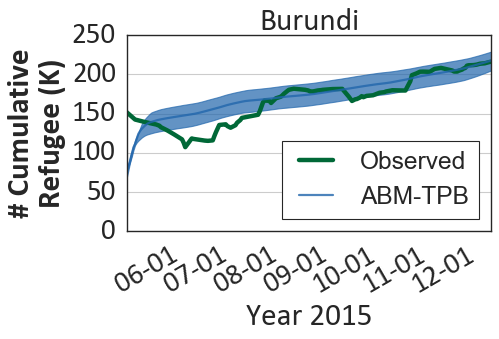

In [19]:
import datetime

trim = 7

median_normal,q1_normal,q3_normal = get_uncertainty(simulation_indices,first_df)
# median_esc,q1_esc,q3_esc = get_uncertainty(simulation_indices[10:-trim],first_df)

# median_normal_unsmooth,q1_normal_unsmooth,q3_normal_unsmooth = get_uncertainty(simulation_indices[0:10-trim],second_df)
# median_esc_unsmooth,q1_esc_unsmooth,q3_esc_unsmooth = get_uncertainty(simulation_indices[10:-trim],second_df)

# median_normal,q1_normal,q3_normal = get_uncertainty([check_single],first_df)
# median_esc,q1_esc,q3_esc = get_uncertainty([check_single+1],first_df)
import seaborn as sns
import datetime
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates

rcParams["font.family"] = "calibri"
rcParams["font.size"] = 32
rcParams["axes.labelsize"] = 28
rcParams["axes.titlesize"] = 28
rcParams["xtick.labelsize"] = 26
rcParams["ytick.labelsize"] = 26

fig,ax = plt.subplots(figsize=(7,5))
plt.xticks(rotation=30)

ax.plot(refugee_data['time'], refugee_data['refugee']/1000,label='Observed',linewidth=4,color='#006837')
sns.set_style('white')

ax.plot(first_df['time'],median_normal/1000,linewidth=2,color='#2166ac',alpha=0.8,label='ABM-TPB')
ax.fill_between(first_df["time"], q1_normal/1000, q3_normal/1000, color='#2166ac',alpha=0.7)

myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(myFmt)

#ax.set_facecolor("white")
sns.set_style('white')

ax.legend(loc='best',ncol=1,fontsize=22)
ax.set_ylabel("# Cumulative\nRefugee (K)",fontweight='bold')
ax.set_xlim([datetime.date(2015, 5, 20), datetime.date(2015, 12, 31)])
ax.set_ylim([0,250])
ax.set_xlabel('Year 2015')
ax.set_title('Burundi')
ax.grid(axis='y')
#print(ax.get_xticks())
fig.tight_layout()
fig.savefig('../Figures/iaai_burundi.png',dpi=350,bbox_inches='tight')

In [20]:

first_df['median'] = median_normal
first_df['q1'] = q1_normal
first_df['q3'] = q3_normal
compare_df = first_df.merge(refugee_data,on='time',how='inner')



In [21]:
pcc = compare_df['median'].corr(compare_df['refugee'])
print(pcc)
rmspe = ((((compare_df['median'] - compare_df['refugee'])/compare_df['refugee'])**2).sum()/compare_df.shape[0])**0.5
print(rmspe)
rmse = ((((compare_df['median'] - compare_df['refugee'])/1)**2).sum()/compare_df.shape[0])**0.5
print(rmse)
mape = (abs((compare_df['median']-compare_df['refugee'])/compare_df['refugee'])).sum()/compare_df.shape[0]
print(mape)

0.8118343884377434
0.1446419617319165
20141.76986104981
0.08345739731818633


In [48]:
median_normal.max()

247074.5714285712

In [22]:
def get_results_for_raion(hyper_comb,region_name, who='refugee',prefix='fresh_calib_batch_simulation',look_until=100,ROLL=7):
    
    f_name = prefix+'_completed_'+str(region_name)+'_'+str(hyper_comb).zfill(5)+'.csv'
        #print(f_name)
    if os.path.isfile(OUTPUT_DIR+f_name):
        true_f_name = f_name
        cur_df = pd.read_csv(OUTPUT_DIR+true_f_name)
        cur_df['time'] = pd.to_datetime(cur_df['time'])
        return float(cur_df[who].sum())
    else:
        return 0.0
    
raion_total_outflow_df = pd.DataFrame(columns=['shapeName','outflow'])

for vv in simulation_indices:
    for adm2 in all_ids:
        raion_total_outflow_df = raion_total_outflow_df.append({'shapeName':adm2,'outflow':get_results_for_raion(vv,adm2,prefix='mim_result')},
                                                              ignore_index=True)
        
raion_out_gdf = gpd.GeoDataFrame(raion_total_outflow_df.groupby('shapeName')['outflow'].mean().reset_index().merge(burundi_gdf[['shapeName','geometry']],on='shapeName',how='inner'))

In [23]:
%%time
hh_data = pd.read_csv(HOUSEHOLD_DIR+'burundi_household_data_ADM2_HDX.csv')

CPU times: user 3.42 s, sys: 558 ms, total: 3.98 s
Wall time: 4.04 s


In [24]:
hh_data['people'] = hh_data['OLD_PERSON']+hh_data['CHILD']+hh_data['ADULT_MALE']+hh_data['ADULT_FEMALE']
hh_data = hh_data.rename(columns={'matching_place_id':'shapeName'})
region_people = hh_data.groupby('shapeName')['people'].sum().reset_index()
region_people

,shapeName,people
0,Bisoro,35868
1,Bubanza,83379
2,Bugabira,93753
3,Buganda,68236
4,Bugarama,32371
...,...,...
113,Songa,53563
114,Tangara,76910
115,Vugizo,44590
116,Vumbi,77606


In [25]:
raion_out_gdf = raion_out_gdf.merge(region_people,on='shapeName',how='outer').fillna(0)

In [26]:
raion_out_gdf

,shapeName,outflow,geometry,people
0,Bisoro,122.777778,"POLYGON ((29.79610 -3.62674, 29.79460 -3.62686...",35868
1,Bubanza,6698.777778,"POLYGON ((29.42655 -3.11489, 29.42431 -3.11723...",83379
2,Bugabira,1305.111111,"POLYGON ((30.10073 -2.42500, 30.09955 -2.42803...",93753
3,Buganda,448.222222,"POLYGON ((29.14367 -2.87410, 29.14493 -2.87444...",68236
4,Bugarama,68.444444,"POLYGON ((29.33631 -3.64856, 29.34259 -3.64737...",32371
...,...,...,...,...
114,Songa,267.333333,"POLYGON ((29.75362 -3.82592, 29.75516 -3.82629...",53563
115,Tangara,140.777778,"POLYGON ((30.17652 -2.90824, 30.17281 -2.91167...",76910
116,Vugizo,726.555556,"POLYGON ((29.67010 -4.07823, 29.67033 -4.07832...",44590
117,Vumbi,463.777778,"POLYGON ((30.17709 -2.60460, 30.18116 -2.60880...",77606


In [27]:
raion_out_gdf['proportion'] = (raion_out_gdf['outflow']/raion_out_gdf['people'])*1000

In [28]:
raion_out_gdf.sort_values(by='proportion',ascending=False).head(20)

,shapeName,outflow,geometry,people,proportion
77,Mukaza,37644.666667,"POLYGON ((29.40077 -3.37888, 29.40143 -3.38339...",124661,301.976293
45,Isale,25179.444444,"POLYGON ((29.45003 -3.38616, 29.44797 -3.38590...",83868,300.227076
74,Muha,35964.555556,"POLYGON ((29.38408 -3.39572, 29.38266 -3.39876...",119798,300.209983
49,Kanyosha1,26023.111111,"POLYGON ((29.40077 -3.37888, 29.40183 -3.37819...",87068,298.882610
93,Ntahangwa,76707.888889,"POLYGON ((29.40335 -3.37942, 29.40183 -3.37819...",257857,297.482282
86,Mutimbuzi,20766.333333,"POLYGON ((29.34569 -3.26444, 29.36724 -3.26184...",69858,297.264928
1,Bubanza,6698.777778,"POLYGON ((29.42655 -3.11489, 29.42431 -3.11723...",83379,80.341306
97,Nyabiraba,3925.111111,"POLYGON ((29.42730 -3.46188, 29.43922 -3.45901...",52569,74.665889
68,Mpanda,4496.000000,"POLYGON ((29.41475 -3.25556, 29.40020 -3.25765...",61223,73.436454
58,Kirundo,5523.222222,"POLYGON ((30.17709 -2.60460, 30.17251 -2.60752...",93846,58.854104


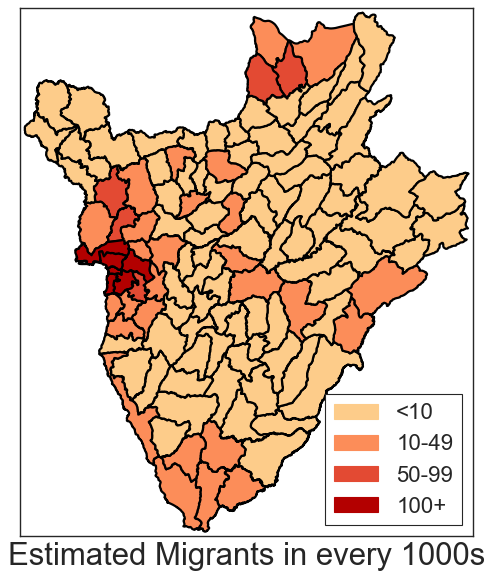

In [39]:
import matplotlib.pyplot as plt

diff_ranges = [ (0, 10), (10, 50), (50, 100), (100,10000)]
diff_colors = ['#fdcc8a','#fc8d59','#e34a33','#b30000']

def diff_to_color(diff):
    if diff<-10000:
        return diff_colors[0]
    for i, (d_min, d_max) in enumerate(diff_ranges):
        if d_min <= diff < d_max:
            return diff_colors[i]
    return diff_colors[-1]

# Create a legend for the color scheme
legend_handles = []
legend_labels = []
for i, (diff_range, diff_color) in enumerate(zip(diff_ranges, diff_colors)):
    legend_handles.append(plt.Rectangle((0, 0), 2, 2, color=diff_color))
    if i == len(diff_ranges) - 1:
        legend_labels.append(f'{diff_range[0]}+')
    elif i==0:
        legend_labels.append(f'<{diff_range[1]}')
    else:
        legend_labels.append(f'{diff_range[0]}-{diff_range[1]-1}')

raion_out_gdf['diff_color'] = raion_out_gdf['proportion'].apply(diff_to_color)

fig,ax = plt.subplots(figsize=(8,8))
ax.set_aspect('equal')

raion_out_gdf.plot(ax=ax,color=raion_out_gdf['diff_color'],edgecolor='black',linewidth=2)

EPS = 0.02
ax.set_xlim(raion_out_gdf.total_bounds[0]-EPS, raion_out_gdf.total_bounds[2]+EPS)
ax.set_ylim(raion_out_gdf.total_bounds[1]-EPS, raion_out_gdf.total_bounds[3]+EPS)
ax.legend(handles=legend_handles,labels=legend_labels,loc='lower right',fontsize=20)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Estimated Migrants in every 1000s')

fig.tight_layout()
fig.savefig('../Figures/burundi_map.png',dpi=350,bbox_inches='tight')

## RUNTIME

In [41]:
import os
loc = '/home/zm8bh/radiation_model/migration_shock/scripts/ABM_Model_Burundi/'

regions = []
tm = []

for f in os.listdir(loc):
    if f.endswith('out'):
        with open(loc+f, 'r') as f:
            first_line = f.readlines()
            if(len(first_line)==4):
                regions.append(first_line[1].strip())
                tm.append((pd.to_datetime(first_line[-1]) - pd.to_datetime(first_line[0])).total_seconds()/60)

Text(0.5, 1.0, 'Runtime Analysis for Burundi')

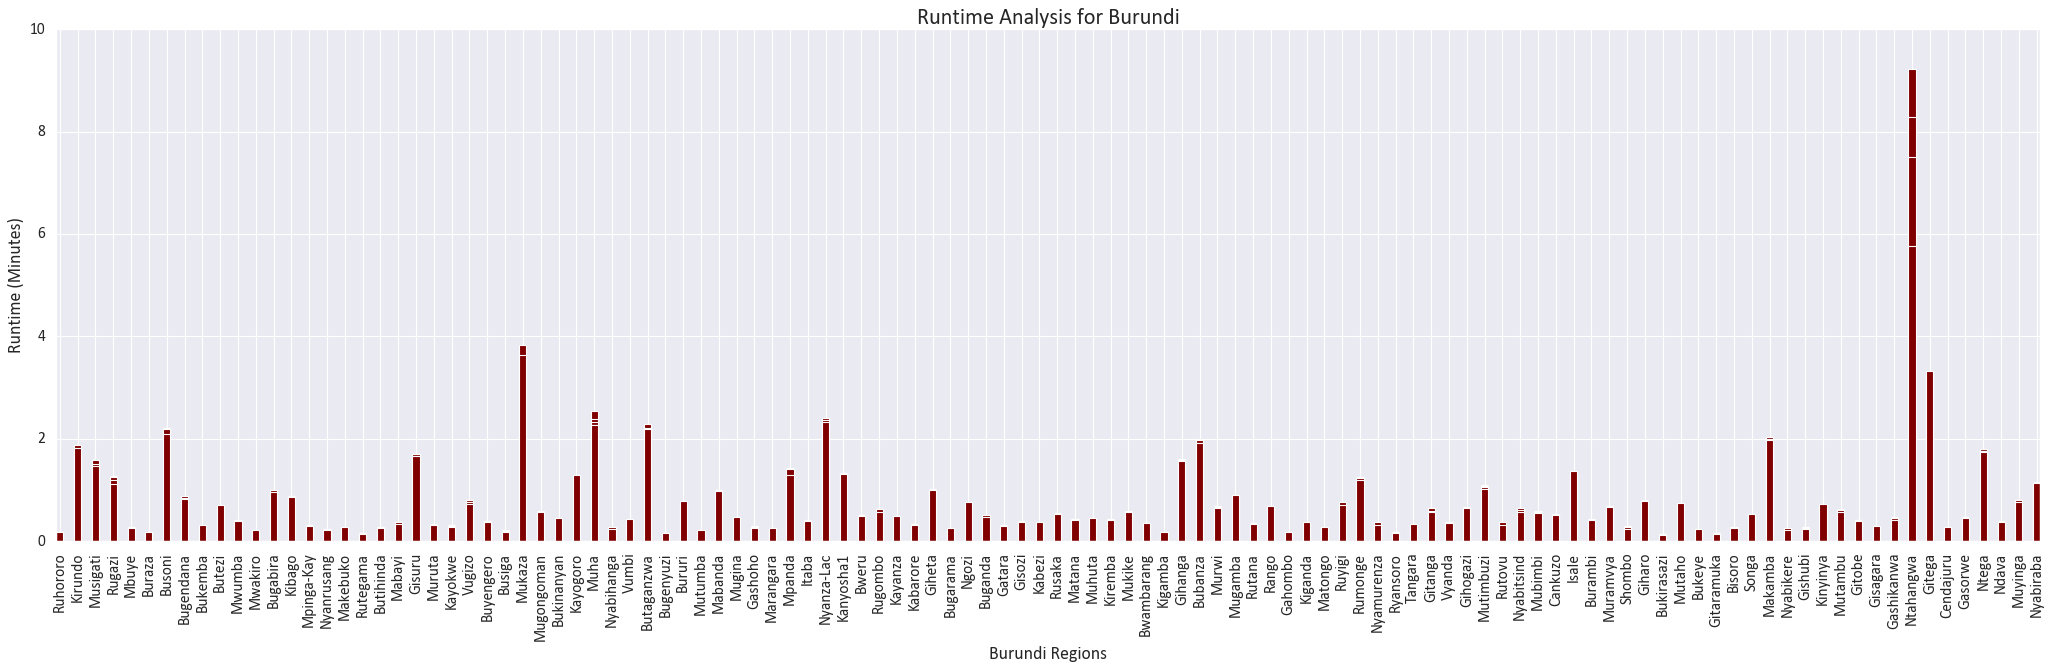

In [44]:
import matplotlib.pyplot as plt
import numpy as np
fig,ax = plt.subplots(figsize=(32,8))
plt.xticks(rotation=90)
rcParams["font.size"] = 24

ax.bar(regions, tm, color ='maroon',width = 0.4)
 
ax.set_xlabel("Burundi Regions")
ax.set_ylabel("Runtime (Minutes)")
ax.set_title("Runtime Analysis for Burundi")


In [45]:
HOUSEHOLD_DATA_PREFIX = 'burundi_household_data_ADM2_HDX.csv'
df = pd.read_csv(HOUSEHOLD_DIR+HOUSEHOLD_DATA_PREFIX)


,hid,OLD_PERSON,CHILD,ADULT_MALE,ADULT_FEMALE,rlid,latitude,longitude,admin1,admin2,geometry,index_right,ADM2_EN,shapeISO,shapeID,shapeGroup,shapeType,matching_place_id
0,1,0,0,1,0,1,-3.713127,30.032571,140001346,160008766,POINT (30.0325712557067 -3.713127423479247),40,Musongati,NaN,21766830B69390357798267,BDI,ADM2,Musongati
1,2,0,1,0,0,2,-3.879417,29.965349,140001355,160008759,POINT (29.96534868159585 -3.879416647405029),41,Rutana,NaN,21766830B742576901715,BDI,ADM2,Rutana
2,3,0,1,0,0,3,-4.019102,29.842910,140001355,160008690,POINT (29.84290970085517 -4.019101616842794),42,Gitanga,NaN,21766830B24659586178873,BDI,ADM2,Gitanga
3,4,0,0,1,0,4,-4.268462,29.764339,140001350,160008754,POINT (29.76433922155728 -4.268461610598333),96,Mabanda,NaN,21766830B88166553647958,BDI,ADM2,Mabanda
4,5,0,0,1,0,5,-3.132511,29.418442,140001341,160008727,POINT (29.41844172394484 -3.132510702038137),23,Mpanda,NaN,21766830B5913384679194,BDI,ADM2,Mpanda


In [48]:
print(df.shape)
print(df['OLD_PERSON'].sum()+df['CHILD'].sum()+df['ADULT_MALE'].sum()+df['ADULT_FEMALE'].sum())

(1775730, 18)
8265888
